In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from jax.scipy.interpolate import RegularGridInterpolator

In [2]:
def gaussian_mgf(eta, sigma=1):
    return jnp.exp((sigma**2 * eta**2)/2)

def exponential_mgf(eta, rate=1):
    return (rate / (rate - eta))

def laplace_mgf(eta, scale=1):
    return (1 / (1 - (scale * eta)**2))
    
def make_cdf(mgf, vmap=True):
    def cdf(eta):
        return jnp.log(mgf(eta))
    cdf_prime = jax.grad(cdf)
    if vmap:
        return jax.jit(jax.vmap(cdf)), jax.jit(jax.vmap(cdf_prime))
    else:
        return jax.jit(cdf), jax.jit(cdf_prime)
        
def make_point_mgf(mgf, pi):
    def point_mgf(eta):
        return (1 - pi) + pi * mgf(eta)
    return point_mgf

def make_mixture_mgf(mgfs, pis):
    def point_mgf(eta):
        mgf_eval = jnp.array([f(eta) for f in mgfs])
        return jnp.sum(pis * mgf_eval)
    return point_mgf
    
def make_penalty(kappa):
    kappa_prime_inv = invert(jax.grad(kappa))
    @jax.jit
    @partial(jax.vmap, in_axes=(0))
    def rho(theta):
        return theta * kappa_prime_inv(theta) - kappa(kappa_prime_inv(theta))
    return rho
    
def point_cdf(eta, sigma=1, pi=0.1):
    return pi * jax.grad(gaussian_mgf)(eta) / (1 - pi + pi * gaussian_mgf(eta))

### A fixed point iteration

$$
\nu_{g, \sigma, t}(\theta) = \kappa^\prime_g((t-\theta)/\sigma^2)) = \theta
$$

Notice that $\nu(t) = 0$ and $\nu(0) = t$ when $g$ is a mean zero prior.
Since it may alternate, I propose taking a running average of the iterates. 
I think a strategy like this should converge to a fixed point. 

In [29]:
# set up prior
mgf = partial(gaussian_mgf, sigma=1)
kappa, kappa_prime = make_cdf(mgf, vmap=False)

def make_shrinkage_op(kappa_prime):
    def shrinkage_op(t, sigma2):
        nu = lambda theta: kappa_prime((t - theta)/sigma2)

        def scanf(x, it):
            nux = nu(x)
            xnew = (it-1)/it * x + (1/it) * nu(x)
            return xnew, nux
            
        return jax.lax.scan(scanf, t/2, np.arange(2, 100))[0]
    return shrinkage_op

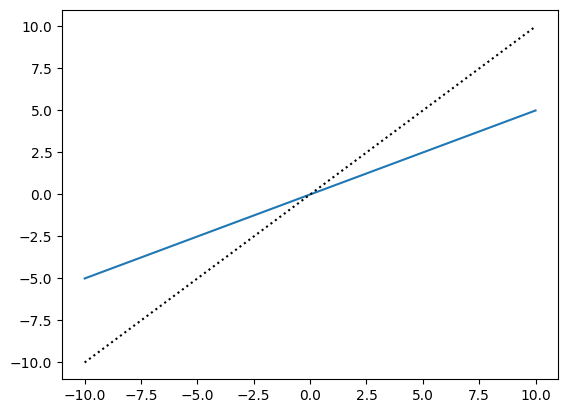

In [30]:
kappa_prime = lambda x: x
S = jax.jit(jax.vmap(partial(make_shrinkage_op(kappa_prime), sigma2=1)))
z = np.linspace(-10, 10, 100)
plt.plot(z, S(z))
plt.plot(z, z, c='k', linestyle='dotted')

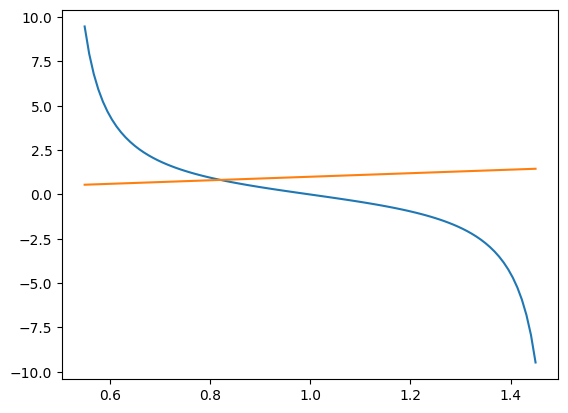

In [66]:
#plt.plot(z, kappa_prime(z))

t = 1
sigma2 = 0.5
z = np.linspace(-0.9, 0.9, 100) * sigma2 + t

nu = lambda theta: kappa_prime((t-theta)/sigma2)
plt.plot(z, nu(z))
plt.plot(z, z)

In [72]:
S = partial(make_shrinkage_op(kappa_prime), sigma2=1)
S(0.5)

Array(0.33633628, dtype=float32)

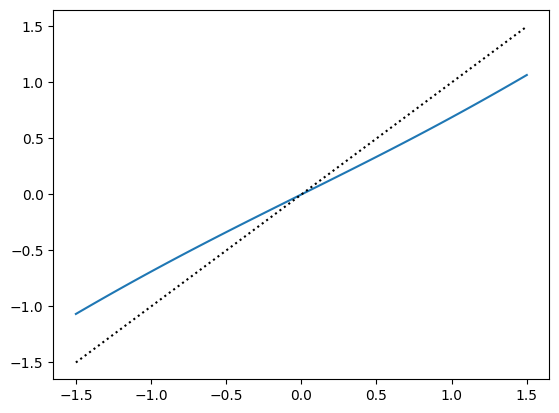

In [34]:
kappa_prime = lambda x: 2*x/(1-x**2)
z = np.linspace(-0.99, 0.99, 100)
#plt.plot(z, kappa_prime(z))
S = jax.jit(jax.vmap(partial(make_shrinkage_op(kappa_prime), sigma2=1)))
plt.plot(z, S(z))
plt.plot(z, z, c='k', linestyle='dotted')

In [66]:
kappa_prime = lambda theta: theta
S = make_shrinkage_operator(kappa_prime)
S(1., 1.)

TracerBoolConversionError: Attempted boolean conversion of traced array with shape bool[].
The error occurred while tracing the function solver_fun_flat at /Users/ktayeb/research/self-tuning-penalty/.venv/lib/python3.13/site-packages/jaxopt/_src/implicit_diff.py:204 for custom_vjp fun. This value became a tracer due to JAX operations on these lines:

  operation a:f32[] = convert_element_type[new_dtype=float32 weak_type=False] b
    from line /Users/ktayeb/research/self-tuning-penalty/.venv/lib/python3.13/site-packages/jaxopt/_src/bisection.py:90:12 (Bisection.init_state)

  operation a:f32[] = convert_element_type[new_dtype=float32 weak_type=False] b
    from line /Users/ktayeb/research/self-tuning-penalty/.venv/lib/python3.13/site-packages/jaxopt/_src/bisection.py:91:12 (Bisection.init_state)

  operation a:f32[] = convert_element_type[new_dtype=float32 weak_type=False] b
    from line /var/folders/0q/xlv6fxx51c17jf27j1ws0wx40000gn/T/ipykernel_77668/229207572.py:9:40 (make_shrinkage_operator.<locals>.shrinkage_op.<locals>.<lambda>)

  operation a:f32[] = convert_element_type[new_dtype=float32 weak_type=False] b
    from line /var/folders/0q/xlv6fxx51c17jf27j1ws0wx40000gn/T/ipykernel_77668/229207572.py:9:39 (make_shrinkage_operator.<locals>.shrinkage_op.<locals>.<lambda>)

  operation a:f32[] = convert_element_type[new_dtype=float32 weak_type=False] b
    from line /var/folders/0q/xlv6fxx51c17jf27j1ws0wx40000gn/T/ipykernel_77668/229207572.py:9:40 (make_shrinkage_operator.<locals>.shrinkage_op.<locals>.<lambda>)

(Additional originating lines are not shown.)
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerBoolConversionError

In [52]:
S(2., 1)

Array(4.000001, dtype=float32)

In [51]:
np.linspace(0, 1, 10)

array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])

In [55]:
Sv = jax.vmap(S, in_axes=(0, None))
Sv(np.linspace(0, 1, 10), 1.)

TracerBoolConversionError: Attempted boolean conversion of traced array with shape bool[].
This BatchTracer with object id 4769498704 was created on line:
  /Users/ktayeb/research/self-tuning-penalty/.venv/lib/python3.13/site-packages/jaxopt/_src/bisection.py:105:9 (Bisection.init_state)
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerBoolConversionError

In [17]:
bisec = Bisection(optimality_fun=f, lower=-1, upper=2)
print(bisec.run().params)

ValueError: vmap was requested to map its argument along axis 0, which implies that its rank should be at least 1, but is only 0 (its shape is ())

In [15]:
F(np.arange(10))

array([ -2,  -2,   4,  22,  58, 118, 208, 334, 502, 718])

In [23]:
theta = 1.
sigma2 = 1.

kappa_prime = lambda theta: theta
f = lambda t: (kappa_prime((t - theta)/sigma2) - theta)
bisec = Bisection(optimality_fun=f, lower=1, upper=4)
bisec.run().params

Array(2.0000076, dtype=float32)

In [109]:
from jaxopt import Bisection
f = lambda t: (kappa_prime((t - theta)/sigma2) - theta)[None]
bisec = Bisection(optimality_fun=f, lower=1, upper=4)
bisec.run().

ValueError: vmap was requested to map its argument along axis 0, which implies that its rank should be at least 1, but is only 0 (its shape is ())

In [91]:
solver = ScipyRootFinding(optimality_fun=f)
solver.run(np.ones(1))

AttributeError: 'NoneType' object has no attribute 'lower'

In [65]:
z[np.abs(f(z)).argmin()]

np.float64(-0.19919919919919926)

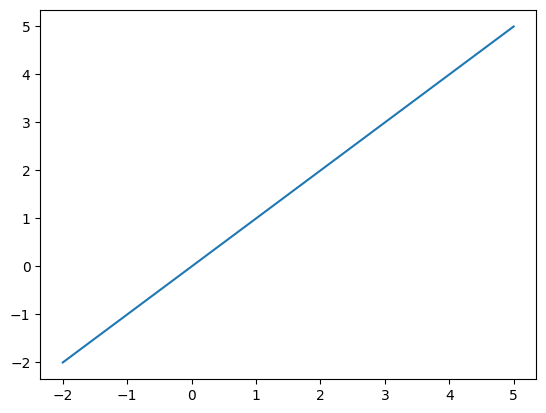

In [54]:
plt.plot(z, kappa_prime(z))

In [38]:
z = np.linspace(-1, 1, 100) * 2
kappa_prime(z)

Array([-2.        , -1.9595959 , -1.919192  , -1.8787879 , -1.8383838 ,
       -1.7979798 , -1.7575758 , -1.7171717 , -1.6767677 , -1.6363636 ,
       -1.5959595 , -1.5555556 , -1.5151515 , -1.4747474 , -1.4343435 ,
       -1.3939394 , -1.3535353 , -1.3131313 , -1.2727273 , -1.2323233 ,
       -1.1919192 , -1.1515151 , -1.1111112 , -1.0707071 , -1.030303  ,
       -0.989899  , -0.94949496, -0.90909094, -0.86868685, -0.82828283,
       -0.7878788 , -0.74747473, -0.7070707 , -0.6666667 , -0.6262626 ,
       -0.5858586 , -0.54545456, -0.5050505 , -0.46464646, -0.42424244,
       -0.3838384 , -0.34343433, -0.3030303 , -0.26262626, -0.22222222,
       -0.18181819, -0.14141414, -0.1010101 , -0.06060606, -0.02020202,
        0.02020202,  0.06060606,  0.1010101 ,  0.14141414,  0.18181819,
        0.22222222,  0.26262626,  0.3030303 ,  0.34343433,  0.3838384 ,
        0.42424244,  0.46464646,  0.5050505 ,  0.54545456,  0.5858586 ,
        0.6262626 ,  0.6666667 ,  0.7070707 ,  0.74747473,  0.78

Text(0, 0.5, 'Penalty')

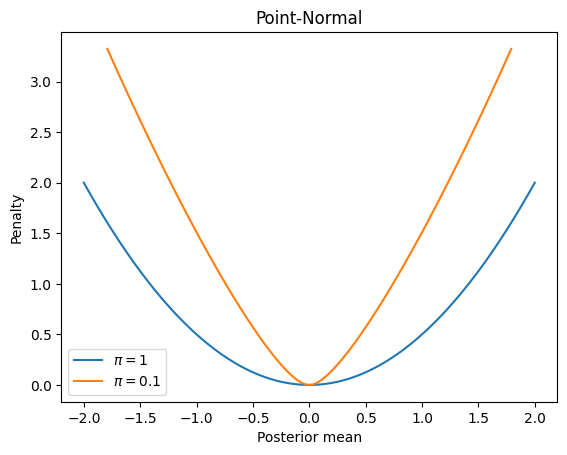

In [3]:
#
mgf = partial(gaussian_mgf, sigma=1)
kappa, kappa_prime = make_cdf(mgf)
z = np.linspace(-1, 1, 100) * 2
theta = kappa_prime(z)
penalty = theta * z - kappa(z)
plt.plot(theta, penalty, label=r'$\pi=1$')

#
mgf = partial(gaussian_mgf, sigma=1)
point_mgf = make_point_mgf(mgf, pi=0.1)
kappa, kappa_prime = make_cdf(point_mgf)
z = np.linspace(-1, 1, 100) * 2.5

theta = kappa_prime(z)
penalty = theta * z - kappa(z)
plt.plot(theta, penalty, label=r'$\pi=0.1$')
plt.legend()
plt.title('Point-Normal')
plt.xlabel('Posterior mean')
plt.ylabel('Penalty')

Text(0, 0.5, 'Penalty')

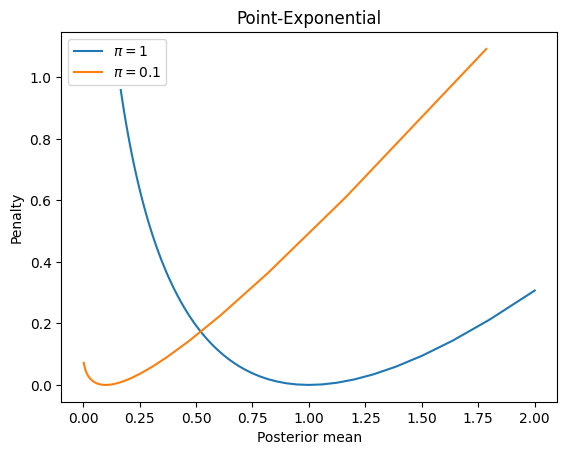

In [4]:
#
mgf = partial(exponential_mgf, rate=1)
kappa, kappa_prime = make_cdf(mgf)
z = np.linspace(-5, 0.5, 100)
theta = kappa_prime(z)
penalty = theta * z - kappa(z)
plt.plot(theta, penalty, label=r'$\pi=1$')

#
mgf = partial(exponential_mgf, rate=1)
point_mgf = make_point_mgf(mgf, pi=0.1)
kappa, kappa_prime = make_cdf(point_mgf)
z = np.linspace(-5, 0.8, 100)
theta = kappa_prime(z)
penalty = theta * z - kappa(z)
plt.plot(theta, penalty, label=r'$\pi=0.1$')
plt.legend()
plt.title('Point-Exponential')
plt.xlabel('Posterior mean')
plt.ylabel('Penalty')

/var/folders/0q/xlv6fxx51c17jf27j1ws0wx40000gn/T/ipykernel_63174/650912464.py:1: RuntimeWarning: invalid value encountered in arcsin
  z = np.arcsin(np.linspace(0, np.pi, 1000))


Text(0, 0.5, 'Penalty')

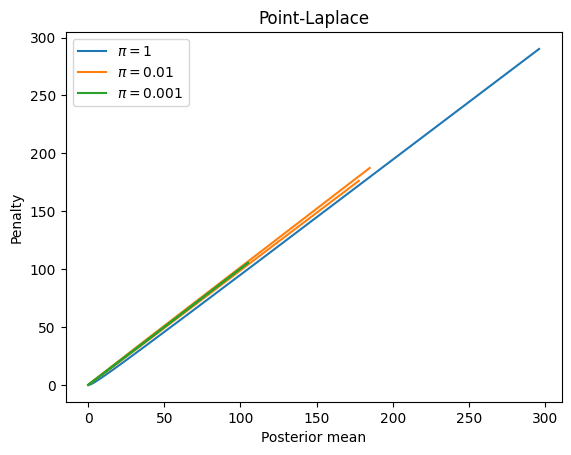

In [27]:
z = np.arcsin(np.linspace(0, np.pi, 1000))

#
mgf = partial(laplace_mgf, scale=1)
kappa, kappa_prime = make_cdf(mgf)
theta = kappa_prime(z)
penalty = theta * z - kappa(z)
plt.plot(theta, penalty, label=r'$\pi=1$')

#
mgf = partial(laplace_mgf, scale=1)
point_mgf = make_point_mgf(mgf, pi=0.1)
kappa, kappa_prime = make_cdf(point_mgf)
theta = kappa_prime(z)
penalty = theta * z - kappa(z)


mgf = partial(laplace_mgf, scale=1)
point_mgf = make_point_mgf(mgf, pi=0.01)
kappa, kappa_prime = make_cdf(point_mgf)
theta = kappa_prime(z)
penalty = theta * z - kappa(z)
plt.plot(theta, penalty, label=r'$\pi=0.01$')

mgf = partial(laplace_mgf, scale=1)
point_mgf = make_point_mgf(mgf, pi=0.001)
kappa, kappa_prime = make_cdf(point_mgf)
theta = kappa_prime(z)
penalty = theta * z - kappa(z)
plt.plot(theta, penalty, label=r'$\pi=0.001$')

plt.legend()
plt.title('Point-Laplace')
plt.xlabel('Posterior mean')
plt.ylabel('Penalty')

Text(0, 0.5, 'Penalty')

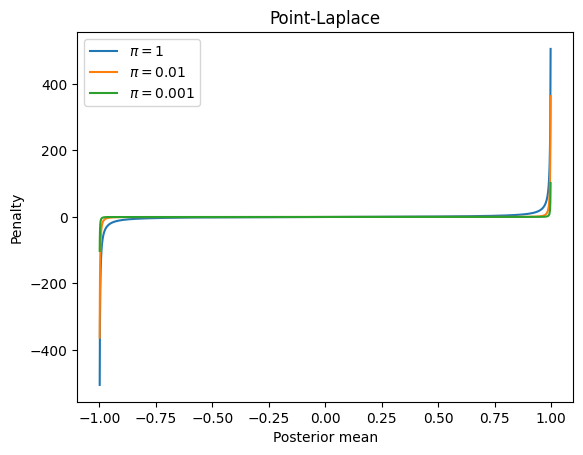

In [34]:
z = np.cos(np.linspace(0, np.pi, 1000))
z = z[20:-20]
#
mgf = partial(laplace_mgf, scale=1)
kappa, kappa_prime = make_cdf(mgf)
theta = kappa_prime(z)
penalty = theta * z - kappa(z)
plt.plot(z, theta, label=r'$\pi=1$')

#
mgf = partial(laplace_mgf, scale=1)
point_mgf = make_point_mgf(mgf, pi=0.1)
kappa, kappa_prime = make_cdf(point_mgf)
theta = kappa_prime(z)
penalty = theta * z - kappa(z)


mgf = partial(laplace_mgf, scale=1)
point_mgf = make_point_mgf(mgf, pi=0.01)
kappa, kappa_prime = make_cdf(point_mgf)
theta = kappa_prime(z)
penalty = theta * z - kappa(z)
plt.plot(z, theta, label=r'$\pi=0.01$')

mgf = partial(laplace_mgf, scale=1)
point_mgf = make_point_mgf(mgf, pi=0.001)
kappa, kappa_prime = make_cdf(point_mgf)
theta = kappa_prime(z)
penalty = theta * z - kappa(z)
plt.plot(z, theta, label=r'$\pi=0.001$')

plt.legend()
plt.title('Point-Laplace')
plt.xlabel('Posterior mean')
plt.ylabel('Penalty')

In [31]:
z

array([ 1.        ,  0.99999506,  0.99998022,  0.9999555 ,  0.99992089,
        0.99987639,  0.999822  ,  0.99975772,  0.99968356,  0.99959951,
        0.99950557,  0.99940175,  0.99928805,  0.99916446,  0.999031  ,
        0.99888765,  0.99873443,  0.99857133,  0.99839835,  0.9982155 ,
        0.99802278,  0.99782019,  0.99760773,  0.9973854 ,  0.99715321,
        0.99691116,  0.99665925,  0.99639749,  0.99612587,  0.9958444 ,
        0.99555308,  0.99525192,  0.99494091,  0.99462007,  0.99428939,
        0.99394887,  0.99359853,  0.99323836,  0.99286837,  0.99248855,
        0.99209893,  0.99169949,  0.99129025,  0.9908712 ,  0.99044235,
        0.99000371,  0.98955528,  0.98909706,  0.98862906,  0.98815128,
        0.98766373,  0.98716641,  0.98665934,  0.9861425 ,  0.98561591,
        0.98507957,  0.9845335 ,  0.98397768,  0.98341214,  0.98283687,
        0.98225188,  0.98165717,  0.98105276,  0.98043865,  0.97981484,
        0.97918134,  0.97853816,  0.9778853 ,  0.97722277,  0.97